<a href="https://colab.research.google.com/github/hxlinh/Fitness_Pose_Correction_Application/blob/main/DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe opencv-python tensorflow keras utils

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 15.7 MB/s eta 0:00:00
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=a5cd1c6bf360b21bc4bd34de25da65eee82c5f02cff8bbea88744059dcc19b89
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, Flatten, Permute, multiply
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import time
from mediapipe.framework.formats import landmark_pb2
import copy
from google.colab import drive
drive.mount('/content/drive')
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns

#Đường dẫn đến thư mục chứa video và lưu trữ landmarks
# VIDEO_PATH = '/content/drive/MyDrive/videos'
# DATA_PATH = '/content/drive/MyDrive/data'

# Đường dẫn đến thư mục chúa video test và lưu trữ landmarks
VIDEO_PATH = '/content/drive/MyDrive/data_test'
DATA_PATH = '/content/drive/MyDrive/data'

Mounted at /content/drive


In [ ]:
def get_bounding_box(results, margin=10):
    if not results.pose_landmarks:
        return None

    landmarks = results.pose_landmarks.landmark
    x_coords = [landmark.x for landmark in landmarks]
    y_coords = [landmark.y for landmark in landmarks]

    x_min = max(min(x_coords) - margin / 100, 0)
    x_max = min(max(x_coords) + margin / 100, 1)
    y_min = max(min(y_coords) - margin / 100, 0)
    y_max = min(max(y_coords) + margin / 100, 1)

    return x_min, x_max, y_min, y_max

In [ ]:
# Thiết lập Mediapipe
mp_pose = mp.solutions.pose

# Biến toàn cục để đếm số thứ tự của sequence trên tất cả video
global_sequence_number = 1

def mediapipe_detection(image, model, bbox=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if bbox is None:
        bbox = get_bounding_box(results)
    if bbox:
        h, w, _ = image.shape
        x_min, x_max, y_min, y_max = bbox
        x_min = int(x_min * w)
        x_max = int(x_max * w)
        y_min = int(y_min * h)
        y_max = int(y_max * h)
        cropped_image = image[y_min:y_max, x_min:x_max]
        if results.pose_landmarks:
            new_pose_landmarks = landmark_pb2.NormalizedLandmarkList()
            for landmark in results.pose_landmarks.landmark:
                new_x = (landmark.x * w - x_min) / (x_max - x_min)
                new_y = (landmark.y * h - y_min) / (y_max - y_min)
                new_x = max(0.0, min(1.0, new_x))
                new_y = max(0.0, min(1.0, new_y))
                new_landmark = landmark_pb2.NormalizedLandmark(
                    x=new_x,
                    y=new_y,
                    z=landmark.z,
                    visibility=landmark.visibility
                )
                new_pose_landmarks.landmark.append(new_landmark)
            new_results = copy.deepcopy(results)
            new_results.pose_landmarks = new_pose_landmarks
            return cropped_image, new_results, bbox
        return cropped_image, results, bbox
    return image, results, bbox

def extract_keypoints(results):
    """ Xử lý và tổ chức keypoints từ mô hình phát hiện pose """
    selected_landmarks = [11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]
    pose = np.array([[res.x, res.y, res.z, res.visibility] for idx, res in enumerate(results.pose_landmarks.landmark) if idx in selected_landmarks]).flatten() if results.pose_landmarks else np.zeros(len(selected_landmarks) * 4)
    return pose

def extract_landmarks_from_video(video_path, action, folder, fps=10):
    global global_sequence_number  # Sử dụng biến toàn cục để giữ thứ tự sequence giữa các video
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)  # FPS của video
    frame_count = 0
    landmarks_all_frames = []

    # Calculate how many frames to skip to capture 10 frames per second
    skip_rate = int(frame_rate / fps)

    # Sử dụng pose model của Mediapipe
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        bbox = None
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Extract frame every 'skip_rate' frames to get approximately 'fps' frames per second
            if frame_count % skip_rate == 0:
                image, results, bbox = mediapipe_detection(frame, pose, bbox)
                keypoints = extract_keypoints(results)
                landmarks_all_frames.append(keypoints)

                # Hiển thị khung hình trên màn hình
                # cv2_imshow(image)
                # if cv2.waitKey(1) & 0xFF == ord('q'):
                #   break

                # Save a sequence of 10 frames
                if len(landmarks_all_frames) == 10:
                    sequence_folder = os.path.join(DATA_PATH, action, str(global_sequence_number))
                    os.makedirs(sequence_folder, exist_ok=True)

                    # Save each frame's landmarks in the sequence folder
                    for frame_idx, frame_landmarks in enumerate(landmarks_all_frames):
                        frame_folder = os.path.join(sequence_folder, f"frame{frame_idx + 1}")
                        os.makedirs(frame_folder, exist_ok=True)
                        np.save(os.path.join(frame_folder, f"{folder}.npy"), frame_landmarks)

                    print(f"Đã lưu sequence {global_sequence_number} từ video {video_path}")
                    landmarks_all_frames = []
                    global_sequence_number += 1

            frame_count += 1

    # Xóa sequence cuối nếu không đủ 10 frames
    if len(landmarks_all_frames) > 0:
        global_sequence_number -= 1  # Giảm số thứ tự sequence vì sequence cuối không hợp lệ
        last_seq_folder = os.path.join(DATA_PATH, action, str(global_sequence_number))
        if os.path.exists(last_seq_folder):
            shutil.rmtree(last_seq_folder)
            print(f"Đã xoá sequence cuối cùng vì không đủ 10 frame từ video {video_path}")

    cap.release()
    # cv2.destroyAllWindows()

def process_all_videos():
    global global_sequence_number
    action_path = os.path.join(VIDEO_PATH, 'plank')
    if os.path.isdir(action_path):
        for folder in os.listdir(action_path):
            folder_path = os.path.join(action_path, folder)
            if os.path.isdir(folder_path):
                video_files = [f for f in os.listdir(folder_path) if f.endswith('.mp4')]

                for video_file in video_files:
                    video_path = os.path.join(folder_path, video_file)
                    print(f"Đang xử lý video: {video_path}")
                    extract_landmarks_from_video(video_path, 'plank', folder)

# Gọi hàm để xử lý tất cả video
process_all_videos()

print("Đã hoàn thành xử lý video và lưu landmarks.")

Đang xử lý video: /content/drive/MyDrive/data_test/plank/1/squat_1.mp4
Đã lưu sequence 1 từ video /content/drive/MyDrive/data_test/plank/1/squat_1.mp4
Đã lưu sequence 2 từ video /content/drive/MyDrive/data_test/plank/1/squat_1.mp4
Đã lưu sequence 3 từ video /content/drive/MyDrive/data_test/plank/1/squat_1.mp4
Đã lưu sequence 4 từ video /content/drive/MyDrive/data_test/plank/1/squat_1.mp4
Đã xoá sequence cuối cùng vì không đủ 10 frame từ video /content/drive/MyDrive/data_test/plank/1/squat_1.mp4
Đang xử lý video: /content/drive/MyDrive/data_test/plank/5/squat_1.mp4
Đã lưu sequence 4 từ video /content/drive/MyDrive/data_test/plank/5/squat_1.mp4
Đã lưu sequence 5 từ video /content/drive/MyDrive/data_test/plank/5/squat_1.mp4
Đã lưu sequence 6 từ video /content/drive/MyDrive/data_test/plank/5/squat_1.mp4
Đã lưu sequence 7 từ video /content/drive/MyDrive/data_test/plank/5/squat_1.mp4
Đã lưu sequence 8 từ video /content/drive/MyDrive/data_test/plank/5/squat_1.mp4
Đã lưu sequence 9 từ video /c

In [ ]:
# Đường dẫn đến tệp landmarks mà bạn muốn tải
landmarks_data_path = '/content/drive/MyDrive/data/squat/1000/frame10/14.npy'

# Tải dữ liệu landmarks từ tệp .npy với allow_pickle=True
landmarks_data = np.load(landmarks_data_path, allow_pickle=True)

# Kiểm tra hình dạng và nội dung
print("Shape of landmarks data:", landmarks_data)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data/squat/1000/frame10/14.npy'

In [ ]:
# Định nghĩa danh sách các action
actions = ['c', '1', '2', '3', '4', '5']  # Ví dụ về các hành động cần phân loại

# Tạo label_map từ các action
label_map = {label: num for num, label in enumerate(actions)}
print("Label map:", label_map)

# Đọc và tổ chức dữ liệu training
sequence_length = 10  # Số frame trong mỗi sequence (có thể thay đổi theo nhu cầu)
sequences, labels = [], []

# Đọc các file từ DATA_PATH

action_path = os.path.join(DATA_PATH, 'plank')  # Đường dẫn tới thư mục action

if os.path.isdir(action_path):  # Kiểm tra nếu thư mục tồn tại
    # Lọc chỉ lấy các thư mục có tên là số (sequence)
    valid_sequences = [seq for seq in os.listdir(action_path) if seq.isdigit()]

    for sequence in valid_sequences:  # Lặp qua các sequence hợp lệ (có tên là số nguyên)
        window = []

        # Lặp qua từng frame trong sequence (frame_num = 0 đến sequence_length - 1)
        for frame_num in range(sequence_length):
            # Tạo đường dẫn đầy đủ tới folder chứa frame
            frame_folder = os.path.join(action_path, sequence, f"frame{frame_num + 1}")

            if os.path.isdir(frame_folder):  # Kiểm tra nếu folder của frame tồn tại
                # Tìm tất cả file .npy trong folder frame
                npy_files = [f for f in os.listdir(frame_folder) if f.endswith('.npy')]

                if npy_files:
                    # Chọn file .npy đầu tiên trong danh sách
                    npy_file = npy_files[0]
                    file_path = os.path.join(frame_folder, npy_files[0])
                    frame_landmarks = np.load(file_path)  # Đọc file numpy chứa landmarks
                    window.append(frame_landmarks)
                    first_letter = npy_file[0].lower()
                else:
                    print(f"Không tìm thấy file .npy nào trong thư mục {frame_folder}")
            else:
                print(f"Thư mục {frame_folder} không tồn tại.")

        # Nếu chúng ta có đủ dữ liệu (sequence_length frame), append vào sequences và labels
        if len(window) == sequence_length:  # Đảm bảo có đủ frame trong mỗi sequence
            sequences.append(window)
            labels.append(label_map[first_letter])  # Gán nhãn tương ứng với action

else:
    print(f"Thư mục {action_path} không tồn tại.")  # Nếu thư mục không tồn tại

# Chuyển đổi thành numpy arrays
X = np.array(sequences)  # Dữ liệu input
y = np.array(labels)  # Nhãn tương ứng với action

print("Dữ liệu đầu vào (X):", X.shape)
print("Nhãn (y):", y.shape)

# One-hot encode labels (chuyển labels thành dạng one-hot)
y = to_categorical(y, num_classes=len(actions)).astype(int)  # Sử dụng num_classes để xác định số lớp

print("Nhãn sau khi one-hot encoding:", y.shape)

# (Optional) Chia dữ liệu thành train/test dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
# print("Dữ liệu train:", X_train.shape, y_train.shape)
# print("Dữ liệu test:", X_test.shape, y_test.shape)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, random_state=2)

# Data test
X_test = X;
y_test = y;

Label map: {'c': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Dữ liệu đầu vào (X): (30, 10, 48)
Nhãn (y): (30,)
Nhãn sau khi one-hot encoding: (30, 6)


In [ ]:
# Callbacks to be used during neural network training
es_callback = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=0, mode='min')
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=0, mode='min')
chkpt_callback = ModelCheckpoint(filepath=DATA_PATH + 'model_checkpoint.keras', monitor='val_loss',
                                 verbose=0, save_best_only=True, save_weights_only=False,
                                 mode='min', save_freq=1)

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# some hyperparamters
batch_size = 32
max_epochs = 500

#LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set up Tensorboard logging and callbacks
NAME = f"ExerciseRecognition-LSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

class CustomCallback(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs=None):
    self.epoch_accuracy = []
    self.epoch_loss = []
  def on_epoch_end(self, epoch, logs=None):
    self.epoch_accuracy.append(logs.get('categorical_accuracy'))
    self.epoch_loss.append(logs.get('loss'))

custom_callback = CustomCallback()
callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback, custom_callback]
lstm = Sequential()
lstm.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(10, 48))) #(sequence_length, input_number)
lstm.add(LSTM(256, return_sequences=True, activation='relu'))
lstm.add(LSTM(128, return_sequences=False, activation='relu'))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dense(64, activation='relu'))
actions = np.array(actions)
lstm.add(Dense(actions.shape[0], activation='softmax'))
print(lstm.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 10, 128)             │          90,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 10, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 707,142 (2.70 MB)

 Trainable params: 707,142 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Recreate the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compile the model
lstm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Train the model
lstm.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 828ms/step - categorical_accuracy: 0.2289 - loss: 2.1416 - val_categorical_accuracy: 0.2115 - val_loss: 1.5759 - learning_rate: 0.0100
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.2280 - loss: 1.5808 - val_categorical_accuracy: 0.1731 - val_loss: 1.5817 - learning_rate: 0.0100
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.2471 - loss: 1.5761 - val_categorical_accuracy: 0.1731 - val_loss: 1.5806 - learning_rate: 0.0100
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.2059 - loss: 1.5494 - val_categorical_accuracy: 0.1731 - val_loss: 1.5950 - learning_rate: 0.0100
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.2054 - loss: 1.5632 - val_categorical_accuracy: 0.2115 - val_loss: 1.5797 - learning_rate: 0.0100
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.2822 - loss: 1.5428 - val_categorical_accuracy: 0.21

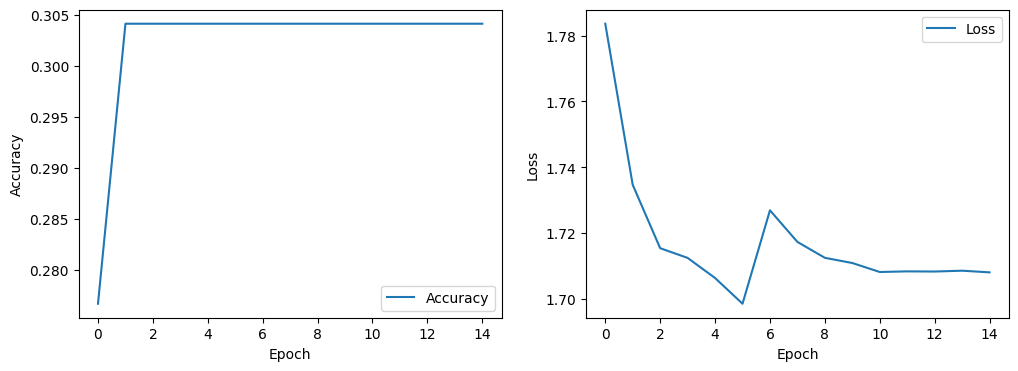

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(custom_callback.epoch_accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(custom_callback.epoch_loss, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#LSTM + Attention

In [ ]:
# Set up Tensorboard logging and callbacks
NAME = f"ExerciseRecognition-AttnLSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

class CustomCallback(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs=None):
    self.epoch_accuracy = []
    self.epoch_loss = []
  def on_epoch_end(self, epoch, logs=None):
    self.epoch_accuracy.append(logs.get('categorical_accuracy'))
    self.epoch_loss.append(logs.get('loss'))

custom_callback = CustomCallback()
callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback, custom_callback]

In [ ]:
def attention_block(inputs, time_steps):
    """
    Attention layer for deep neural network

    """
    # Attention weights
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)

    # Attention vector
    a_probs = Permute((2, 1), name='attention_vec')(a)

    # Luong's multiplicative score
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul')

    return output_attention_mul

In [ ]:
HIDDEN_UNITS = 256

# Input
inputs = Input(shape=(10, 48)) #(sequence_length, input_number)

# Bi-LSTM
lstm_out = Bidirectional(LSTM(HIDDEN_UNITS, return_sequences=True))(inputs)

# Attention
attention_mul = attention_block(lstm_out, 10) #sequence length
attention_mul = Flatten()(attention_mul)

# Fully Connected Layer
x = Dense(2*HIDDEN_UNITS, activation='relu')(attention_mul)
x = Dropout(0.5)(x)

# Output
x = Dense(actions.shape[0], activation='softmax')(x)

# Bring it all together
AttnLSTM = Model(inputs=[inputs], outputs=x)
print(AttnLSTM.summary())

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 10, 48)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 10, 512)        │        624,640 │ input_layer_11[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_5 (Permute)       │ (None, 512, 10)        │              0 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 512, 10)        │            110 │ permute_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_vec (Permute)   │ (None, 10, 512)        │              0 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mul (Multiply)  │ (None, 10, 512)        │              0 │ bidirectional_5[0][0], │
│                           │                        │                │ attention_vec[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 5120)           │              0 │ attention_mul[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 512)            │      2,621,952 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512)            │              0 │ dense_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 6)              │          3,078 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,249,780 (12.40 MB)

 Trainable params: 3,249,780 (12.40 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Recreate the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# Recompile the model with the new optimizer
AttnLSTM.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Train the model
AttnLSTM.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=[callbacks])


Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - categorical_accuracy: 0.1799 - loss: 1.8927 - val_categorical_accuracy: 0.3654 - val_loss: 2.2142 - learning_rate: 0.0100
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.2720 - loss: 1.6523 - val_categorical_accuracy: 0.2115 - val_loss: 1.7054 - learning_rate: 0.0100
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.2494 - loss: 1.5874 - val_categorical_accuracy: 0.2500 - val_loss: 1.5942 - learning_rate: 0.0100
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.2843 - loss: 1.5257 - val_categorical_accuracy: 0.3077 - val_loss: 1.5493 - learning_rate: 0.0100
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.2846 - loss: 1.5166 - val_categorical_accuracy: 0.1923 - val_loss: 1.8035 - learning_rate: 0.0100
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.3285 - loss: 1.4817 - val_categorical_accuracy: 0.2885

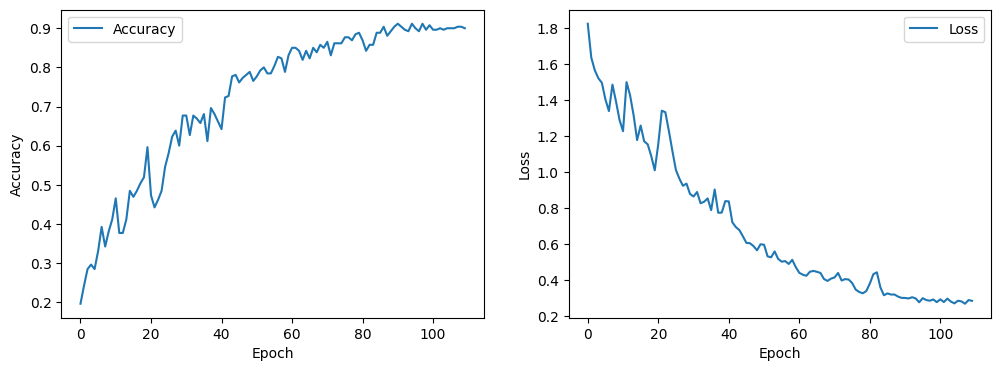

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(custom_callback.epoch_accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(custom_callback.epoch_loss, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#Lưu model

In [ ]:
# Model map
models = {
    'LSTM_plank': lstm,
    'LSTM_Attention_plank': AttnLSTM,
}

In [ ]:
for model_name, model in models.items():
    # Define the save directory in /content/
    save_dir = os.path.join('/content/drive/MyDrive/model', f"{model_name}.h5")
    model.save(save_dir)

In [ ]:
# Run model rebuild before doing this
for model_name, model in models.items():
    # Define the load directory in /content/
    load_dir = os.path.join('/content/drive/MyDrive/result/new1/plank', f"{model_name}.h5")
    model.load_weights(load_dir)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


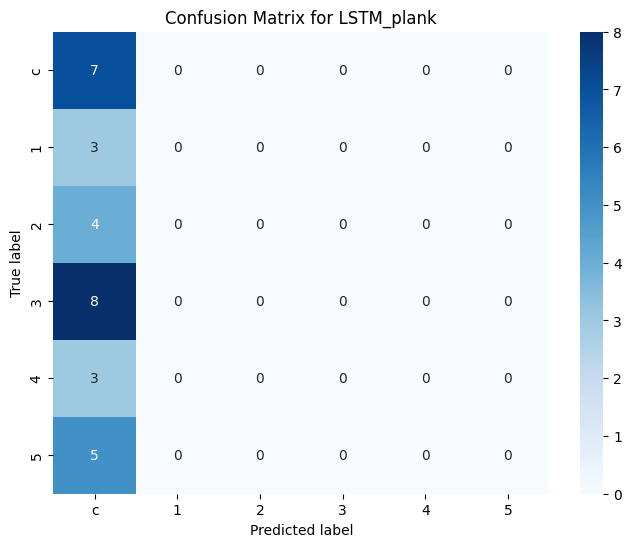

Classification Report for LSTM_plank:
              precision    recall  f1-score   support

           c       0.23      1.00      0.38         7
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         5

    accuracy                           0.23        30
   macro avg       0.04      0.17      0.06        30
weighted avg       0.05      0.23      0.09        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


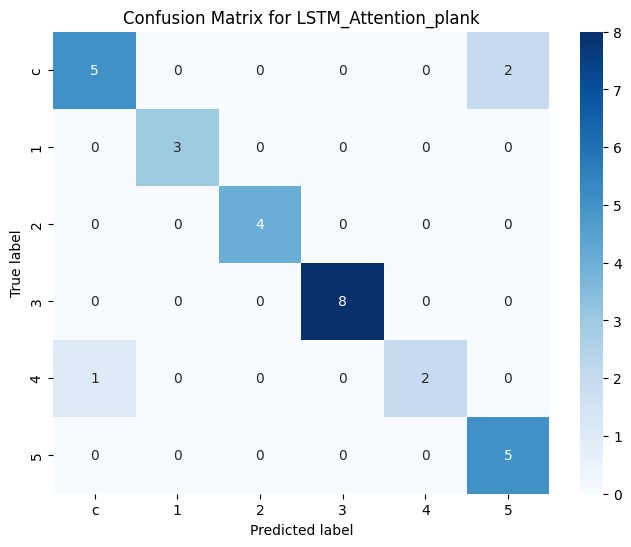

Classification Report for LSTM_Attention_plank:
              precision    recall  f1-score   support

           c       0.83      0.71      0.77         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         8
           4       1.00      0.67      0.80         3
           5       0.71      1.00      0.83         5

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.90        30
weighted avg       0.91      0.90      0.90        30



In [ ]:
#Bảo
eval_results = {}
confusion_matrices = {}
classification_reports = {}

for model_name, model in models.items():
  # Predict on test data
  yhat = model.predict(X_test, verbose=0)

  # Convert predictions and true labels to class indices
  ytrue = np.argmax(y_test, axis=1).tolist()
  yhat = np.argmax(yhat, axis=1).tolist()

  # Confusion matrix
  cm = confusion_matrix(ytrue, yhat)
  confusion_matrices[model_name] = cm

  # Classification report
  report = classification_report(ytrue, yhat, target_names=actions, output_dict=True)
  classification_reports[model_name] = report

  # Print confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title(f'Confusion Matrix for {model_name}')
  plt.show()

  # Print classification report
  print(f"Classification Report for {model_name}:")
  print(classification_report(ytrue, yhat, target_names=actions))

eval_results['confusion matrix'] = confusion_matrices
eval_results['classification report'] = classification_reports

In [ ]:
for model in models.values():
    res = model.predict(X_test, verbose=0)

In [ ]:
eval_results = {}
eval_results['confusion matrix'] = None
eval_results['accuracy'] = None
eval_results['precision'] = None
eval_results['recall'] = None
eval_results['f1 score'] = None

confusion_matrices = {}
classification_accuracies = {}
precisions = {}
recalls = {}
f1_scores = {}

In [ ]:
# Initialize confusion matrices for each model
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)

    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()

    # Confusion matrix
    confusion_matrices[model_name] = confusion_matrix(ytrue, yhat)

# Collect results
eval_results['confusion matrix'] = confusion_matrices

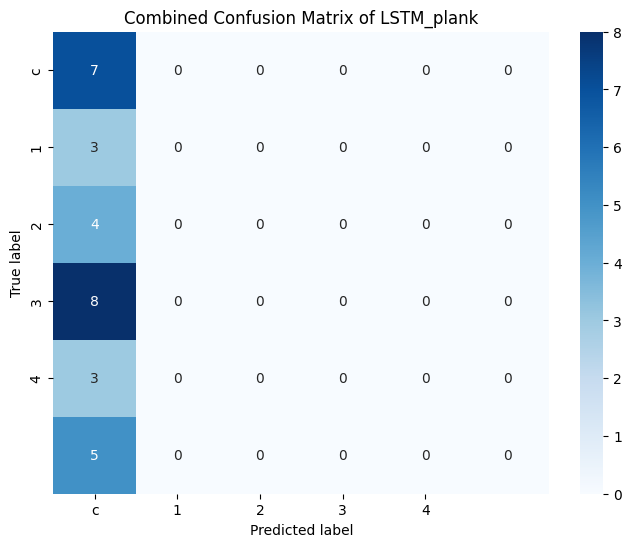

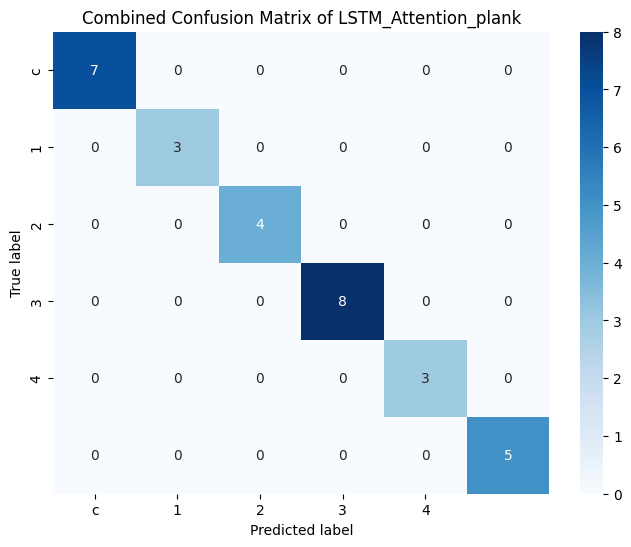

In [ ]:
for model_name, cm in confusion_matrices.items():
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['c', '1', '2', '3', '4'], yticklabels=['c', '1', '2', '3', '4'])
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title(f'Combined Confusion Matrix of {model_name}')
  plt.show()

In [ ]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)

    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()

    # Model accuracy
    classification_accuracies[model_name] = accuracy_score(ytrue, yhat)
    print(f"{model_name} classification accuracy = {round(classification_accuracies[model_name]*100,3)}%")

# Collect results
eval_results['accuracy'] = classification_accuracies

LSTM_squat classification accuracy = 25.714%
LSTM_Attention_squat classification accuracy = 94.286%


In [ ]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)

    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()

    # Get unique classes
    unique_classes = np.unique(ytrue)

    # Precision, recall, and f1 score
    report = classification_report(ytrue, yhat, target_names=actions, labels=unique_classes, output_dict=True)

    precisions[model_name] = report['weighted avg']['precision']
    recalls[model_name] = report['weighted avg']['recall']
    f1_scores[model_name] = report['weighted avg']['f1-score']

    print(f"{model_name} weighted average precision = {round(precisions[model_name], 3)}")
    print(f"{model_name} weighted average recall = {round(recalls[model_name], 3)}")
    print(f"{model_name} weighted average f1-score = {round(f1_scores[model_name], 3)}\n")

# Collect results
eval_results['precision'] = precisions
eval_results['recall'] = recalls
eval_results['f1 score'] = f1_scores


LSTM_squat weighted average precision = 0.066
LSTM_squat weighted average recall = 0.257
LSTM_squat weighted average f1-score = 0.105

LSTM_Attention_squat weighted average precision = 0.955
LSTM_Attention_squat weighted average recall = 0.943
LSTM_Attention_squat weighted average f1-score = 0.944



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
